<a href="https://colab.research.google.com/github/aryashivakumar/dataScience/blob/main/Unit4/Arya_Kumar_Unit4Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part I: Introduction**

For my Unit 4 Project, I plan to use hierarchial and nonhierchial models in order to determine the change in cyrptocurrency prices. More specifically, I want to see if there are any connections between XRP, Bitcoin, Ethereum, and Solana.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# **Data**

I imported 3 months (a quarter) of open and close price data from the four cryptocurrencies mentioned in the introduction and then utilized Google Sheets in order to sort the data into a useful spreadsheet.
Then I made a column with the diffrence of close and open data to find the change of price data on the daily time frame.

In [3]:
url_currency_data = 'https://raw.githubusercontent.com/aryashivakumar/dataScience/refs/heads/main/Unit4/DailyDeFIData2Months%20-%20Data%20(1).csv'
crypto_data = pd.read_csv(url_currency_data)

crypto_data

,Date,CryptoCurrency,Close,Open,Change %
0,10/29/2025,XRP,2.6474,2.6037,-0.02
1,10/28/2025,XRP,2.6039,2.634,0.01
2,10/27/2025,XRP,2.6341,2.6461,0.00
3,10/26/2025,XRP,2.6462,2.5961,-0.02
4,10/25/2025,XRP,2.5961,2.5106,-0.03
...,...,...,...,...,...
243,09/02/2025,Solana,209.604,197.14,-0.06
244,09/01/2025,Solana,197.249,200.37,0.02
245,08/31/2025,Solana,200.675,202.86,0.01
246,08/30/2025,Solana,202.71,204.77,0.01


Stock data in the panda dataframe above

(array([  2.,   9.,  14.,  76., 105.,  27.,  11.,   1.,   1.,   2.]),
 array([-0.11 , -0.084, -0.058, -0.032, -0.006,  0.02 ,  0.046,  0.072,
         0.098,  0.124,  0.15 ]),
 <BarContainer object of 10 artists>)

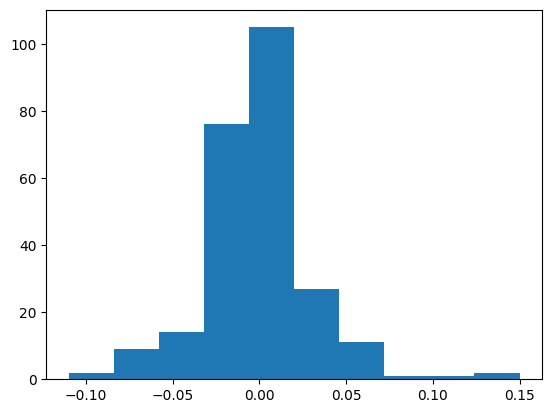

In [4]:
plt.hist(crypto_data['Change %'], bins = 10)

In [5]:
crypto_data['Change %'] = crypto_data['Change %'].astype(str).str.replace(',', '', regex=False)
crypto_data['Change %'] = pd.to_numeric(crypto_data['Change %'])

print(crypto_data['Change %'].mean())
print(crypto_data['Change %'].median())

0.000967741935483871
0.0


There appears to be a slight negative skew

In [6]:
crypto_encode = pd.Categorical(crypto_data['CryptoCurrency'])
crypto_index = crypto_encode.codes
crypto_coords = {"Currency": crypto_encode.categories}

print(crypto_encode)
print(crypto_index)
print(crypto_coords)

['XRP', 'XRP', 'XRP', 'XRP', 'XRP', ..., 'Solana', 'Solana', 'Solana', 'Solana', 'Solana']
Length: 248
Categories (4, object): ['Bitcoin', 'Ethereum', 'Solana', 'XRP']
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
{'Currency': Index(['Bitcoin', 'Ethereum', 'Solana', 'XRP'], dtype='object')}


# **Nonhierarchical Models**

In [ ]:
with pm.Model(coords=crypto_coords) as crypto_nh_model:
    #priors
    #dims="aa" means to apply the prior seperately to each amino acid
    μ = pm.Normal('μ', mu=0, sigma=10,
                  dims="Currency")
    σ = pm.HalfNormal('σ', sigma=10,
                      dims="Currency")
    y = pm.Normal('y',
                  mu = μ[crypto_index],
                  sigma = σ[crypto_index],
                  observed = crypto_data["Change %"])
    idata_crypto_nh = pm.sample()


In [ ]:
pm.sample_posterior_predictive(idata_crypto_nh, model = crypto_nh_model, extend_inferencedata=True)


(-0.2, 0.2)

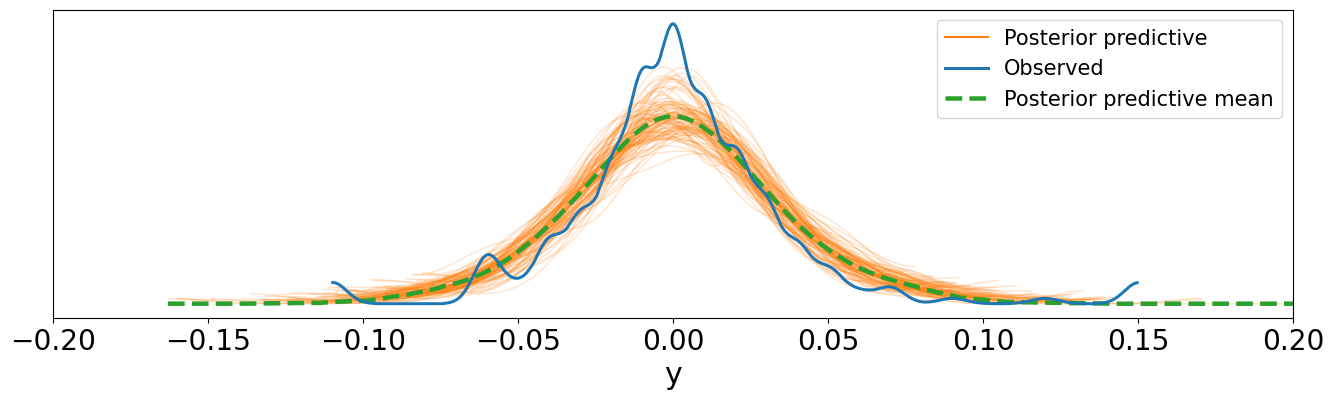

In [9]:
helloBitcoin = az.plot_ppc(idata_crypto_nh, num_pp_samples=100, figsize=(16, 4), colors=["C1", "C0", "C2"])
helloBitcoin.set_xlim(-0.2, 0.2)

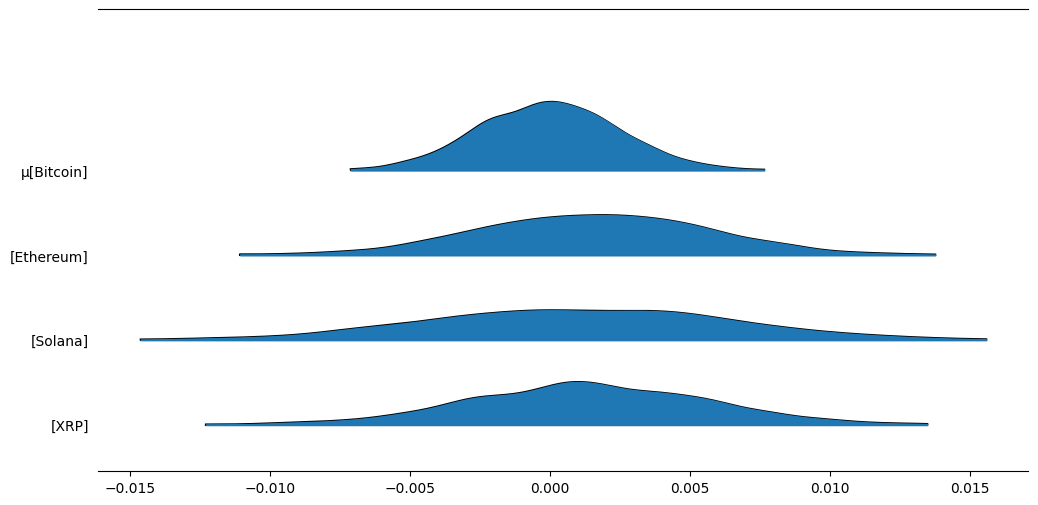

In [10]:
axes = az.plot_forest(idata_crypto_nh, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 6), hdi_prob=0.997)

My initial model is alright, however it dosen't really take into account the higher values in the posterior predictive curve which also didn't fully take the observed data into the curve.

# **Second nonhierarchical model**


In [ ]:
with pm.Model(coords=crypto_coords) as crypto_nh_model_2:

    μ = pm.Uniform('μ', lower=-0.1, upper=0.15, dims="Currency")

    #the same as before
    σ = pm.HalfNormal('σ', sigma=5, dims="Currency")

    #this is our normality parameter; lam = 1/1100 gives a mean of 0.0009
    ν = pm.Exponential('ν', lam = 1/1100, dims="Currency")

    #new likelihood, same data
    y = pm.StudentT('y', mu=μ[crypto_index], sigma=σ[crypto_index], nu = ν[crypto_index], observed=crypto_data["Change %"])
    idata_crypto_2 = pm.sample(target_accept = 0.95)

In [ ]:
pm.sample_posterior_predictive(idata_crypto_2, model = crypto_nh_model_2, extend_inferencedata=True)

(-0.2, 0.2)

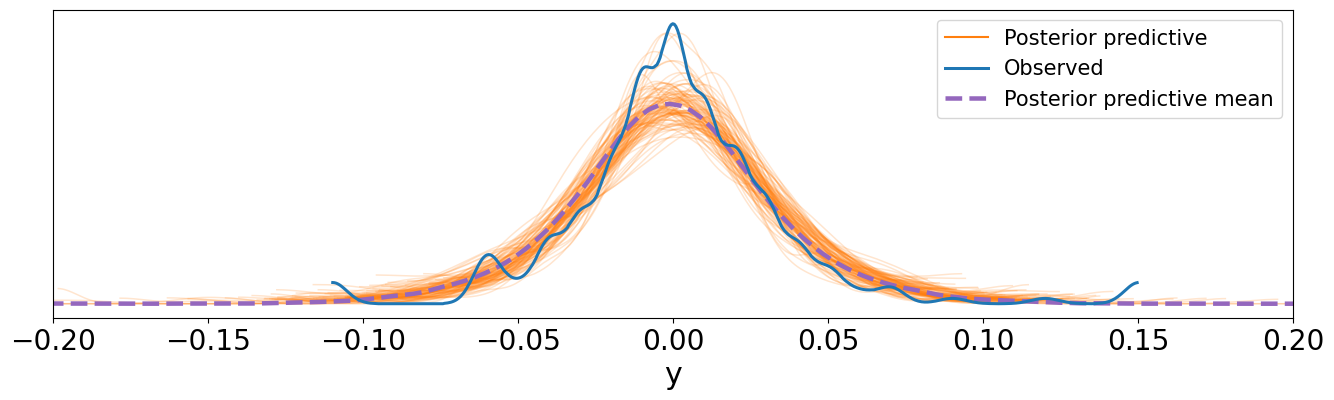

In [43]:
helloBitcoin2 = az.plot_ppc(idata_crypto_2, num_pp_samples=100, figsize=(16, 4), colors=["C1", "C0", "C4"])
helloBitcoin2.set_xlim(-0.2, 0.2)

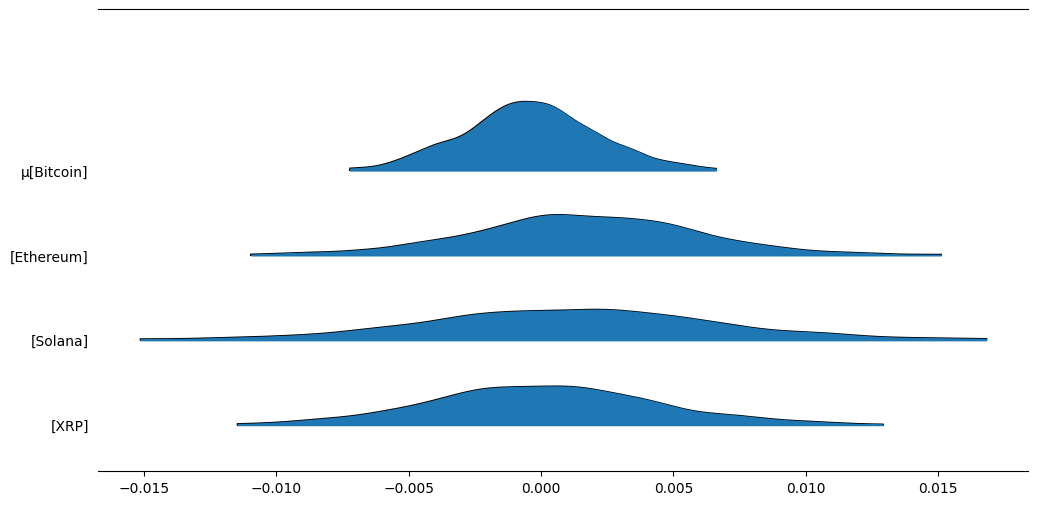

In [39]:
axes = az.plot_forest(idata_crypto_2, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 6), hdi_prob=0.997)

As we can see I switched  my model to a StudentT, which helped bring the curve up a little bit, however in order to further improve my model I will now move onto the hierachial model portion of the project.

# **First Hierachial Model**

We are now moving onto Hierachial models which have shared hyperpriors and assume levels of of dependence between groups.

In [ ]:
with pm.Model(coords=crypto_coords) as crypto_h_model:

  μ_mu = pm.Normal('μ_mu', mu=0, sigma=5)
  σ_mu = pm.HalfNormal('σ_mu', sigma=3)
  ν_mu = pm.Exponential('ν_mu', lam=0.5)

  μ = pm.StudentT('μ', mu=μ_mu, sigma=σ_mu, nu=ν_mu, dims="Currency")
  σ = pm.HalfNormal('σ', sigma=10, dims="Currency")
  ν = pm.Exponential('ν', lam=0.5, dims="Currency")

  y = pm.StudentT('y', mu=μ[crypto_index], sigma=σ[crypto_index], nu=ν[crypto_index],
                  observed=crypto_data["Change %"])

  idata_crypto_h = pm.sample(target_accept = 0.99)

In [ ]:
pm.sample_posterior_predictive(idata_crypto_h, model=crypto_h_model, extend_inferencedata=True)

(-0.2, 0.2)

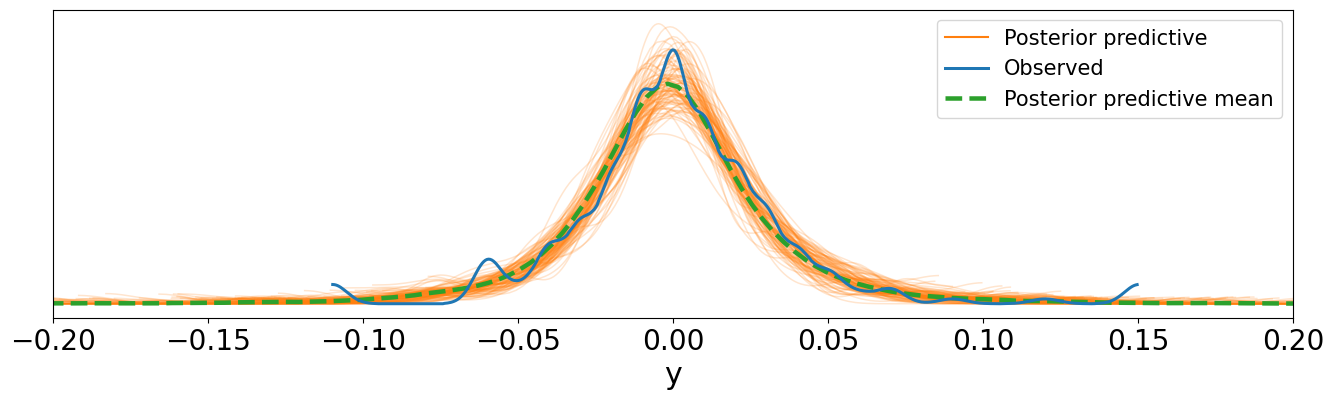

In [47]:
ax = az.plot_ppc(idata_crypto_h, num_pp_samples=100, figsize=(16, 4), colors=["C1", "C0", "C2"])
ax.set_xlim(-0.2, 0.2)

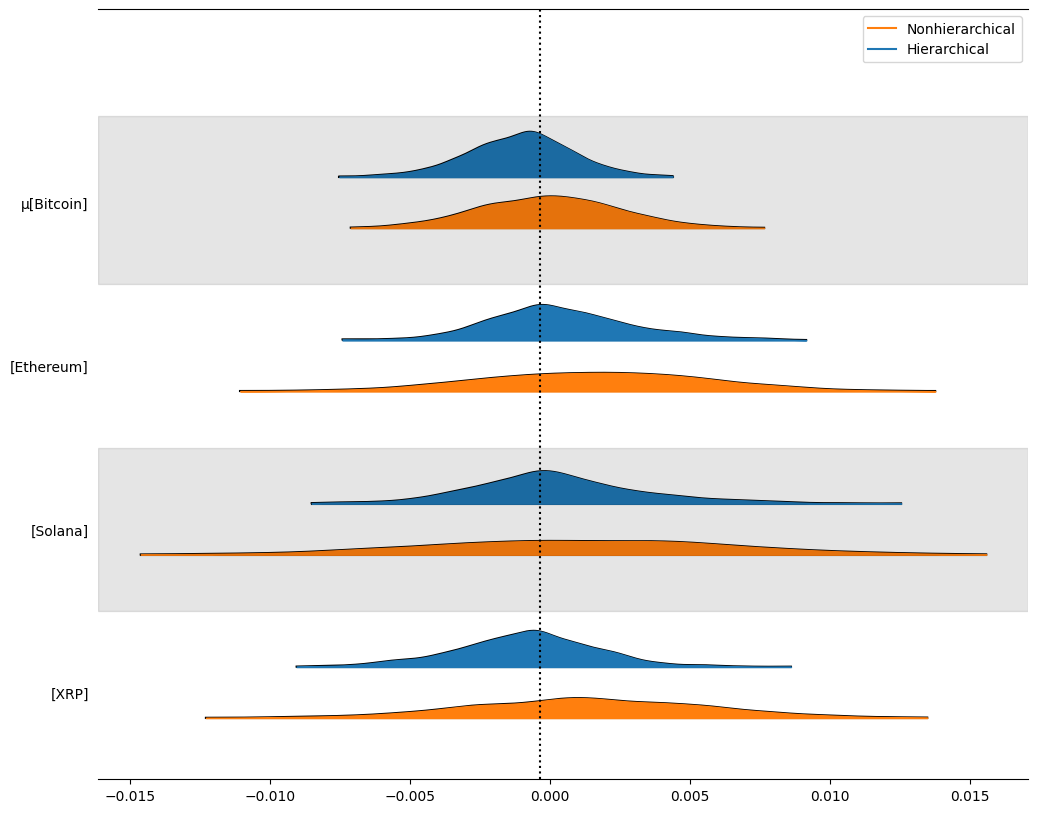

In [48]:
axes = az.plot_forest([idata_crypto_h, idata_crypto_nh], kind="ridgeplot",
                      model_names=['Hierarchical', 'Nonhierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_crypto_h.posterior['μ'].mean(), *y_lims, color="k", ls=":");

<xarray.Dataset> Size: 248B
Dimensions:   (Currency: 4)
Coordinates:
  * Currency  (Currency) <U8 128B 'Bitcoin' 'Ethereum' 'Solana' 'XRP'
Data variables:
    μ         (Currency) float64 32B 1.0 1.003 1.001 1.003
    μ_mu      float64 8B 1.003
    ν         (Currency) float64 32B 1.002 1.004 1.001 1.003
    ν_mu      float64 8B 1.004
    σ         (Currency) float64 32B 1.004 1.001 1.0 1.003
    σ_mu      float64 8B 1.012

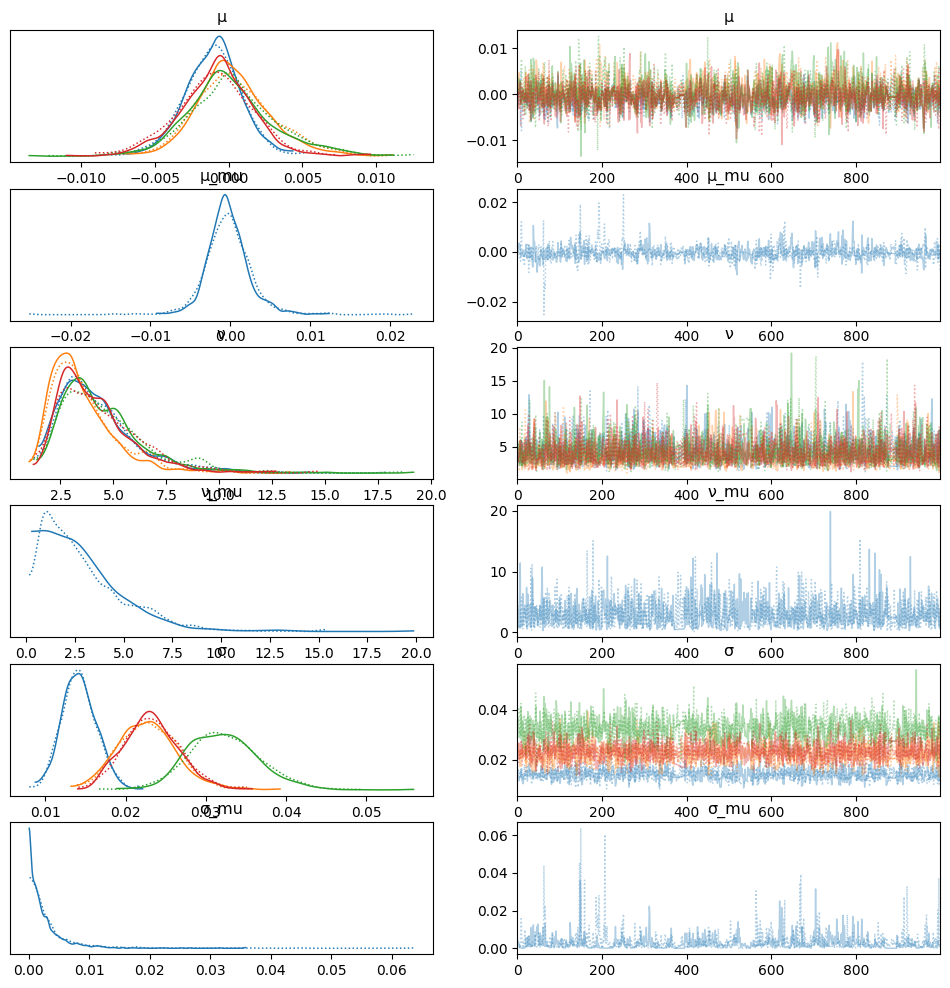

In [49]:
az.plot_trace(idata_crypto_h)
az.rhat(idata_crypto_h)

This model fits the data quite well. The R-hat values and traces also are still good, we can observe the shrinkage that the hierachial model has done by looking at the ridgeplots. I believe this is my best hierchial model I can make for now.

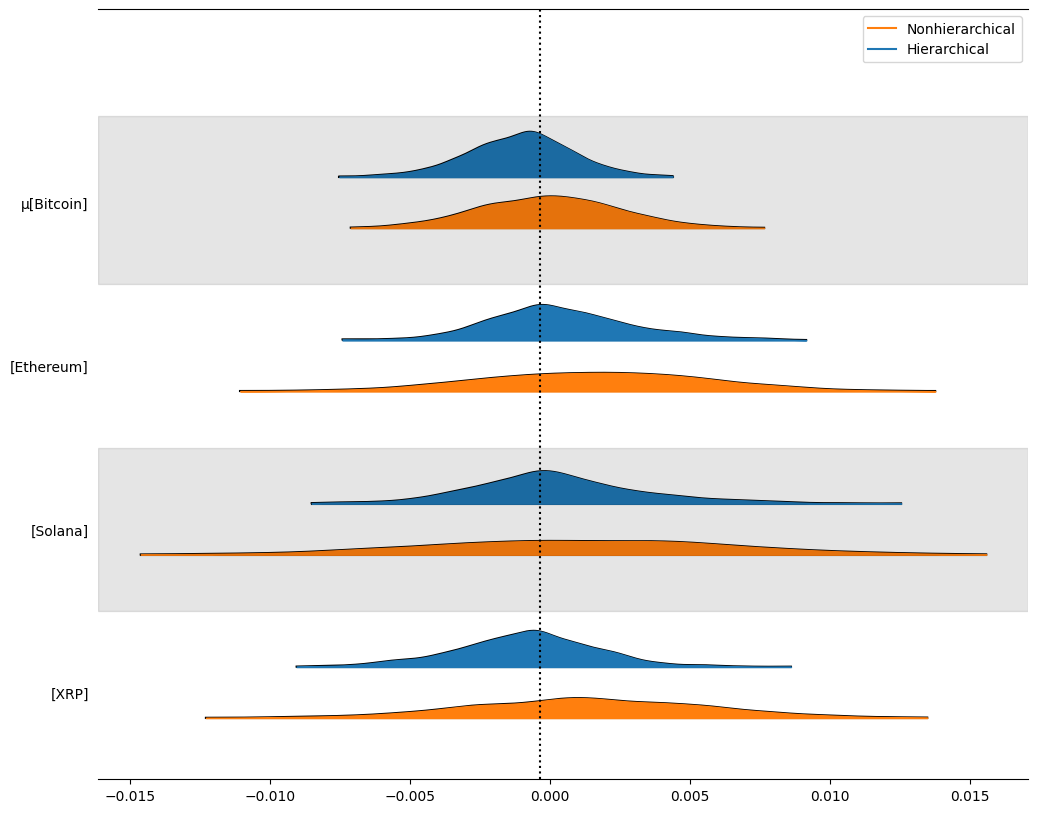

In [51]:
axes = az.plot_forest([idata_crypto_h, idata_crypto_nh], kind="ridgeplot",
                      model_names=['Hierarchical', 'Nonhierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_crypto_h.posterior['μ'].mean(), *y_lims, color="k", ls=":");

I've plotted the ridgeplots to compare above for both nonhierachial and hierachial.

The means are around -0.001,  with the hierarchial models being similar to the mean.

This means the companies make -0.001 on average.

This period appears to be relatively unsuccessful for the cryptocurrencies mentioned.

Thanks!